# Recommender System Testing

The focus of this notebook is to test various code snippest, processing, subcomponents and integration of subcomponents for the recommender system

## Data Processing

External databases are initially used to test and train the recommender system so no actual pre-processing is required for that but when an online version is created and data is logged this will need to be processed and stored. For now the csv ratings file will be loaded and mappings will be created from user and movie ids to indexes. A sparse matrix will then be created to make indexing much easier, for this project double indexing will be done as it is more efficient than having a full sparse matrix.

In [1]:
import csv
import time
import os
import random
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

In [2]:
# Choose small or large dataset: False=small, True=large
# large_dataset = True
large_dataset = False

if(large_dataset):
    folder_name = "../data/external/ml-32m"
else:
    folder_name = "../data/external/ml-latest-small"
file_name = "ratings.csv" 
file_path = os.path.join(folder_name, file_name) # Combines folder and file name correctly

# User and movie mappings
user_to_idx = {}
idx_to_user = {}
movie_to_idx = {}
idx_to_movie = {}

# Sparse Lists for user and movie ratings
user_ratings_train = []
user_ratings_test = []
movie_ratings_train = []
movie_ratings_test = []

start_time = time.time()
try:
    with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        header = next(csv_reader)
        for row in csv_reader:
            user_id = row[0]
            movie_id = row[1]
            rating = float(row[2])

            if user_id not in user_to_idx:
                user_idx = len(user_to_idx)
                user_to_idx[user_id] = user_idx
                idx_to_user[user_idx] = user_id
                user_ratings_test.append([])
                user_ratings_train.append([])

            if movie_id not in movie_to_idx:
                movie_idx = len(movie_to_idx)
                movie_to_idx[movie_id] = movie_idx
                idx_to_movie[movie_idx] = movie_id
                movie_ratings_train.append([]) 
                movie_ratings_test.append([])

            rand = random.random()
            if rand < 0.8:
                user_ratings_train[user_to_idx[user_id]].append((movie_to_idx[movie_id], rating))
                movie_ratings_train[movie_to_idx[movie_id]].append((user_to_idx[user_id], rating))
            else:
                user_ratings_test[user_to_idx[user_id]].append((movie_to_idx[movie_id], rating))
                movie_ratings_test[movie_to_idx[movie_id]].append((user_to_idx[user_id], rating))

except FileNotFoundError:
    print(f"File {file_path} not found.")
except Exception as e:
    print(f"An error occurred: {e}")

end_time = time.time()
print("Finished")
print("Time taken:", end_time - start_time, "seconds")


Finished
Time taken: 0.5779328346252441 seconds


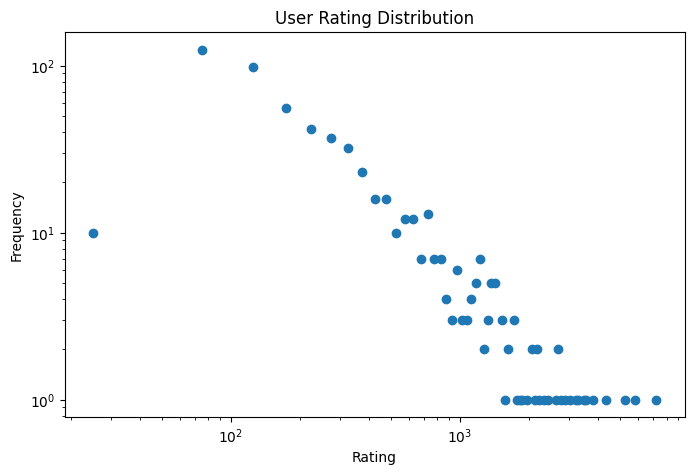

In [ ]:
user_total_ratings = []

for row in user_ratings_train:
    user_sum = sum([rating for _, rating in row])
    user_total_ratings.append(user_sum)

all_user_ratings = [rating for rating in user_total_ratings]
user_rating_counts = Counter(all_user_ratings)
user_ratings = np.array(sorted(user_rating_counts.keys()))
user_frequencies = np.array([user_rating_counts[r] for r in user_ratings])

user_bin_edges = np.arange(0, max(user_total_ratings) + 10, 10)
user_frequencies, user_bins = np.histogram(user_total_ratings, bins=user_bin_edges)
user_bin_centers = 0.5 * (user_bins[1:] + user_bins[:-1])

plt.figure(figsize=(8,5))
plt.scatter(user_bin_centers, user_frequencies)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('User Rating Distribution')
plt.show()

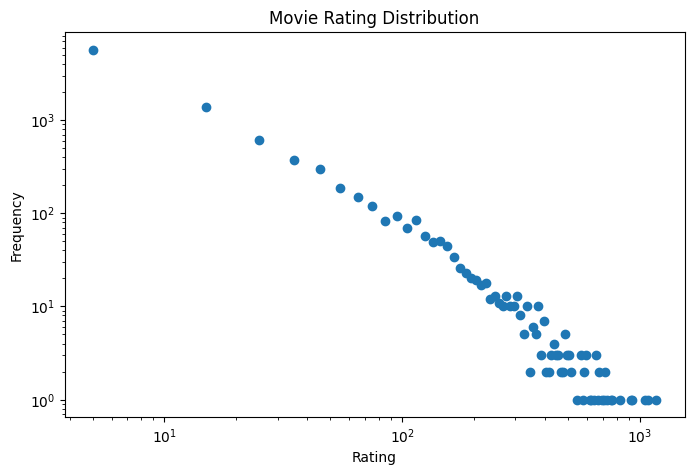

In [16]:
movie_total_ratings = []

for row in movie_ratings_train:
    movie_sum = sum([rating for _, rating in row])
    movie_total_ratings.append(movie_sum)

all_movie_ratings = [rating for rating in movie_total_ratings]
movie_rating_counts = Counter(all_movie_ratings)
movie_ratings = np.array(sorted(movie_rating_counts.keys()))
movie_frequencies = np.array([movie_rating_counts[r] for r in movie_ratings])

movie_bin_edges = np.arange(0, max(movie_total_ratings) + 10, 10)
movie_frequencies, movie_bins = np.histogram(movie_total_ratings, bins=movie_bin_edges)
movie_bin_centers = 0.5 * (movie_bins[1:] + movie_bins[:-1])

plt.figure(figsize=(8,5))
plt.scatter(movie_bin_centers, movie_frequencies)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Movie Rating Distribution')
plt.show()

In [13]:
# Hyperparameters
lam = 0.1
gamma = 0.1
num_epochs = 100

# Configure Biases
user_biases = np.zeros(len(user_ratings_train))
item_biases = np.zeros(len(movie_ratings_train))
training_loss = []
training_RMSE = []
testing_RMSE = []

# Estimate biases with loss function
for epoch in range(num_epochs):
    for u in range(len(user_ratings_train)):
        bias = 0
        counter = 0
        for movie_idx, rating in user_ratings_train[u]:
            bias += lam * (rating - item_biases[movie_idx])
            counter += 1
        bias = bias / ((lam * counter) + gamma)
        user_biases[u] = bias

    for m in range(len(movie_ratings_train)):
        bias = 0
        counter = 0
        for user_idx, rating in movie_ratings_train[m]:
            bias += lam * (rating - user_biases[user_idx])
            counter += 1
        bias = bias / ((lam * counter) + gamma)
        item_biases[m] = bias

    loss = 0
    user_sum = 0
    item_sum = 0
    count = 0
    for u, user_ratings in enumerate(user_ratings_train):
        for movie_idx, rating in user_ratings:
            user_sum += user_biases[u]**2
            item_sum += item_biases[movie_idx]**2
            pred = user_biases[u] + item_biases[movie_idx]
            loss += (rating - pred)**2
            count += 1
    train_rmse = np.sqrt(loss / count)
    loss += lam * (user_sum + item_sum)
    training_loss.append(loss)
    training_RMSE.append(train_rmse)

    loss = 0
    count = 0
    for u, user_ratings in enumerate(user_ratings_test):
        for movie_idx, rating in user_ratings:
            pred = user_biases[u] + item_biases[movie_idx]
            loss += (rating - pred)**2
            count += 1
    test_rmse = np.sqrt(loss / count)
    testing_RMSE.append(test_rmse)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

Epoch 1/100, Loss: 15359.5526, Train RMSE: 0.8042, Test RMSE: 0.8804
Epoch 2/100, Loss: 14932.3989, Train RMSE: 0.7907, Test RMSE: 0.8680
Epoch 3/100, Loss: 14898.5817, Train RMSE: 0.7897, Test RMSE: 0.8670
Epoch 4/100, Loss: 14886.9500, Train RMSE: 0.7895, Test RMSE: 0.8667
Epoch 5/100, Loss: 14879.7828, Train RMSE: 0.7894, Test RMSE: 0.8665
Epoch 6/100, Loss: 14875.2473, Train RMSE: 0.7894, Test RMSE: 0.8664
Epoch 7/100, Loss: 14872.5827, Train RMSE: 0.7894, Test RMSE: 0.8663
Epoch 8/100, Loss: 14871.3004, Train RMSE: 0.7894, Test RMSE: 0.8663
Epoch 9/100, Loss: 14871.0587, Train RMSE: 0.7895, Test RMSE: 0.8662
Epoch 10/100, Loss: 14871.6042, Train RMSE: 0.7895, Test RMSE: 0.8663
Epoch 11/100, Loss: 14872.7419, Train RMSE: 0.7896, Test RMSE: 0.8663
Epoch 12/100, Loss: 14874.3176, Train RMSE: 0.7896, Test RMSE: 0.8663
Epoch 13/100, Loss: 14876.2087, Train RMSE: 0.7896, Test RMSE: 0.8664
Epoch 14/100, Loss: 14878.3170, Train RMSE: 0.7897, Test RMSE: 0.8665
Epoch 15/100, Loss: 14880.564

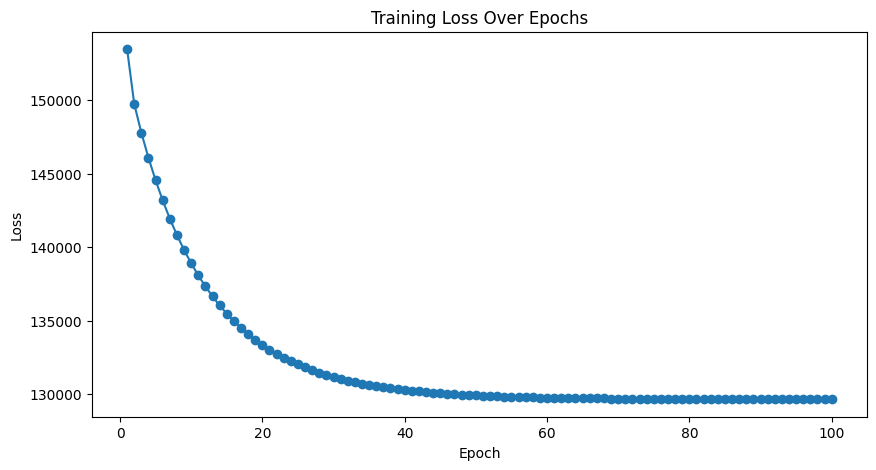

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_loss, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()
    

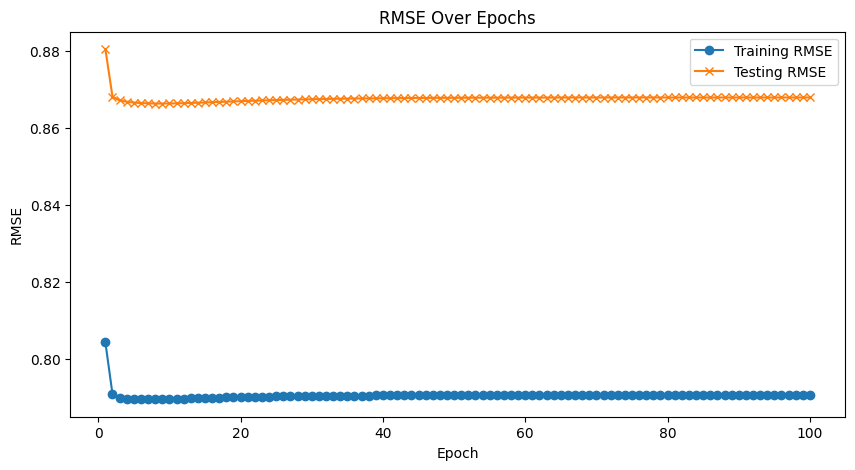

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_RMSE, marker='o', label='Training RMSE')
plt.plot(range(1, num_epochs + 1), testing_RMSE, marker='x', label='Testing RMSE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE Over Epochs')
plt.show()